## IMDb

At Fast.ai we have introduced a new module called fastai.text which replaces the torchtext library that was used in our 2018 dl1 course. The fastai.text module also supersedes the fastai.nlp library but retains many of the key functions.

In [2]:
from fastai.text import *
import html

In [6]:
BOS = 'xbos'  # beginning-of-sentence tag. <pad> are being replaced with xbos in the code below
FLD = 'xfld'  # data field tag

PATH=Path('data/ja_lm/')

## Standardize format

In [12]:
LM_PATH=Path('data/ja-lm/')

## Language model tokens

In this section, we start cleaning up the messy text. There are 2 main activities we need to perform:

1. Clean up extra spaces, tab chars, new ln chars and other characters and replace them with standard ones
2. Use the awesome [spacy](http://spacy.io) library to tokenize the data. Since spacy does not provide a parallel/multicore version of the tokenizer, the fastai library adds this functionality. This parallel version uses all the cores of your CPUs and runs much faster than the serial version of the spacy tokenizer.

Tokenization is the process of splitting the text into separate tokens so that each token can be assigned a unique index. This means we can convert the text into integer indexes our models can use.

We use an appropriate chunksize as the tokenization process is memory intensive

In [8]:
chunksize=24000

In [9]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('<pad>', 'xbos').replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

In [17]:
def get_texts(text):
    text = fixup(text)
    tok = Tokenizer().proc_all_mp(partition_by_cores([text]))
    return tok

In [18]:
with open(LM_PATH/'sample.txt', 'r') as f:
    text = f.read()

In [19]:
tok_all = get_texts(text)

In [24]:
tok_all = tok_all[0]

In [25]:
tok_all[:100]

['obd',
 'xbos',
 'i',
 'do',
 'nt',
 'know',
 'we',
 'bought',
 'it',
 'second',
 'hand',
 'xbos',
 'no',
 'xbos',
 'changwdfuellineandfilterwontidleor',
 'runwhenmovedtoruncutsoff',
 'xbos',
 'raizen',
 ',',
 'xbos',
 'motor',
 'stops',
 ',',
 'runs',
 'only',
 'on',
 'half',
 'choke',
 'with',
 'my',
 'finger',
 'on',
 'throttle',
 '.',
 'xbos',
 'my',
 'microwave',
 'is',
 "n't",
 'heating',
 '.',
 'the',
 'backlight',
 'is',
 'dim',
 'and',
 'the',
 'plate',
 'is',
 'spinning',
 'though',
 'xbos',
 'i',
 'do',
 "n't",
 'think',
 'so',
 '.',
 'xbos',
 'the',
 'battery',
 'is',
 'fine',
 'xbos',
 'i',
 'removed',
 'the',
 'cap',
 '<',
 'num',
 '>',
 'days',
 'ago',
 'easily',
 'to',
 'replace',
 'string',
 'on',
 'weed',
 'eater',
 '.',
 'the',
 'cap',
 'will',
 'not',
 'come',
 'off',
 'now',
 'xbos',
 '<',
 'num',
 '>',
 'sebring',
 'with',
 '<',
 'num',
 '>',
 '<',
 'num',
 '>']

In [26]:
train_size = int(len(tok_all) * 0.8)
tok_trn = tok_all[:train_size]
tok_val = tok_all[train_size:]

In [28]:
len(tok_trn), len(tok_val)

(1854416, 463605)

In [29]:
(LM_PATH/'tmp').mkdir(exist_ok=True)

In [30]:
np.save(LM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val.npy', tok_val)

In [31]:
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val.npy')

In [32]:
freq = Counter(tok_trn)
freq.most_common(25)

[('xbos', 134500),
 ('>', 60775),
 ('<', 60753),
 ('i', 60644),
 ('num', 60517),
 ('the', 52397),
 ('.', 47794),
 ('and', 37725),
 ('it', 36088),
 ('a', 34406),
 ('to', 34200),
 ('is', 27039),
 ('my', 23921),
 ('no', 22816),
 (',', 22109),
 ('on', 19876),
 ('have', 15778),
 ('in', 14328),
 ('not', 14187),
 ("n't", 13076),
 ('of', 12326),
 ('just', 11965),
 ('?', 11862),
 ('but', 11854),
 ('for', 10689)]

The *vocab* is the **unique set of all tokens** in our dataset. The vocab provides us a way for us to simply replace each word in our datasets with a unique integer called an index.

In a large corpus of data one might find some rare words which are only used a few times in the whole dataset. We discard such rare words and avoid trying to learn meaningful patterns out of them.

Here we have set a minimum frequency of occurence to 2 times. It has been observed by NLP practicioners that a maximum vocab of 60k usually yields good results for classification tasks. So we set maz_vocab to 60000.

In [33]:
max_vocab = 60000
min_freq = 2

In [34]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

We create a reverse mapping called stoi which is useful to lookup the index of a given token. stoi also has the same number of elements as itos. We use a high performance container called [collections.defaultdict](https://docs.python.org/2/library/collections.html#collections.defaultdict) to store our stoi mapping.

In [35]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

13270

In [37]:
trn_lm = np.array([stoi[o] for o in tok_trn])
val_lm = np.array([stoi[o] for o in tok_val])

In [38]:
trn_lm[:10]

array([3216,    2,    5,   27,   79,   45,   51,  209,   10,  521])

In [39]:
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

In [40]:
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

In [41]:
vs=len(itos)
vs,len(trn_lm)

(13270, 1854416)

## Language model

It is fairly straightforward to create a new language model using the fastai library. Like every other lesson, our model will have a backbone and a custom head. The backbone in our case is the IMDB LM pre-trained with wikitext and the custom head is a linear classifier. In this section we will focus on the backbone LM and the next section will talk about the classifier custom head.

bptt (*also known traditionally in NLP LM as ngrams*) in fastai LMs is approximated to a std. deviation around 70, by perturbing the sequence length on a per-batch basis. This is akin to shuffling our data in computer vision, only that in NLP we cannot shuffle inputs and we have to maintain statefulness. 

Since we are predicting words using ngrams, we want our next batch to line up with the end-points of the previous mini-batch's items. batch-size is constant and but the fastai library expands and contracts bptt each mini-batch using a clever stochastic implementation of a batch. (original credits attributed to [Smerity](https://twitter.com/jeremyphoward/status/980227258395770882))

In [42]:
em_sz,nh,nl = 400,1150,3

In [43]:
wd=1e-7
bptt=70
bs=52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

The goal of the LM is to learn to predict a word/token given a preceeding set of words(tokens). We take all the movie reviews in both the 90k training set and 10k validation set and concatenate them to form long strings of tokens. In fastai, we use the `LanguageModelLoader` to create a data loader which makes it easy to create and use bptt sized mini batches. The  `LanguageModelLoader` takes a concatenated string of tokens and returns a loader.

We have a special modeldata object class for LMs called `LanguageModelData` to which we can pass the training and validation loaders and get in return the model itself.

In [45]:
trn_dl = LanguageModelLoader(trn_lm, bs, bptt)
val_dl = LanguageModelLoader(val_lm, bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

We setup the dropouts for the model - these values have been chosen after experimentation. If you need to update them for custom LMs, you can change the weighting factor (0.7 here) based on the amount of data you have. For more data, you can reduce dropout factor and for small datasets, you can reduce overfitting by choosing a higher dropout factor. *No other dropout value requires tuning*

In [46]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

We first tune the last embedding layer so that the missing tokens initialized with mean weights get tuned properly. So we freeze everything except the last layer.

We also keep track of the *accuracy* metric.

In [47]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)

In [18]:
#learner.model.load_state_dict(wgts)

We set learning rates and fit our IMDB LM. We first run one epoch to tune the last layer which contains the embedding weights. This should help the missing tokens in the wikitext103 learn better weights.

In [48]:
lr=1e-3
lrs = lr

In [49]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      8.284209   8.225927   0.019402  



[array([8.22593]), 0.01940205018300741]

Note that we print out accuracy and keep track of how often we end up predicting the target word correctly. While this is a good metric to check, it is not part of our loss function as it can get quite bumpy. We only minimize cross-entropy loss in the LM.

The exponent of the cross-entropy loss is called the perplexity of the LM. (low perplexity is better).

In [50]:
learner.save('lm_last_ft')

In [51]:
learner.load('lm_last_ft')

In [52]:
learner.unfreeze()

In [53]:
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      4.311358   4.155034   0.269496  



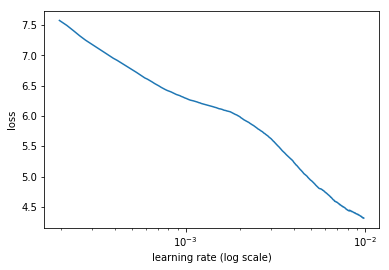

In [54]:
learner.sched.plot()

In [55]:
lr=1e-2
lrs = lr

In [56]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15)

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      4.338075   4.187584   0.265449  
    1      4.007585   3.923489   0.290619                   
    2      3.833172   3.829198   0.298687                   
    3      3.737661   3.799874   0.303824                   
    4      3.662678   3.766303   0.306802                   
    5      3.591003   3.75308    0.309757                   
    6      3.516284   3.748219   0.312229                   
    7      3.481189   3.735672   0.314683                   
    8      3.424691   3.729395   0.315913                   
    9      3.390266   3.720599   0.317099                   
    10     3.291512   3.729558   0.318311                   
    11     3.243947   3.726276   0.31811                    
    12     3.201562   3.723577   0.318906                   
    13     3.179143   3.722916   0.319556                   
    14     3.112871   3.725837   0.319838                   



[array([3.72584]), 0.31983793830123247]

We save the trained model weights and separately save the encoder part of the LM model as well. This will serve as our backbone in the classification task model.

In [57]:
learner.save('lm1')

In [58]:
learner.save_encoder('lm1_enc')

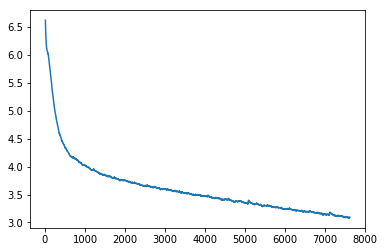

In [59]:
learner.sched.plot_loss()

## Test the model

In [113]:
m=learner.model
ss="""xbos check engine"""
s = [Tokenizer().proc_text(ss)]
t = np.array([stoi[o] for o in s[0]])
' '.join(s[0])

'xbos check engine'

In [114]:
t = t.reshape((1, t.shape[0]))
t = V(t, volatile=True)

In [115]:
# Set batch size to 1
m[0].bs=1
# Turn off dropout
m.eval()
# Reset hidden state
m.reset()
# Get predictions from model
res,*_ = m(t)
# Put the batch size back to what it was
m[0].bs=bs

In [116]:
nexts = torch.topk(res[-1], 10)[1]
[itos[o] for o in to_np(nexts)]

['light',
 'management',
 'oil',
 'is',
 'running',
 'wo',
 'turns',
 'does',
 'malfunction',
 'check']

In [117]:
print(ss,"\n")
for i in range(50):
    n=res[-1].topk(2)[1]
    n = n[1] if n.data[0]==0 else n[0]
    print(itos[n.data[0]], end=' ')
    res,*_ = m(n[0].unsqueeze(0))
print('...')

xbos check engine 

light on dash xbos i have a < num > < num > ford taurus and the check engine light is on . i have changed the fuel pump and fuel filter . xbos no xbos i have a < num > < num > ford taurus and the check ...
